In [1]:
# This Code will backtest a Time Series Momentum Asset Class strategy
# It will also highlight the utility of it when combined with traditional Beta (S&P500)

In [2]:
from MalekFinance import mean,vol,sharpe,skw
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pyfolio as pf
import datetime as dt
from pandas.tseries.offsets import MonthEnd
import pyfolio as pf
import yfinance as yfin
from itertools import chain
plt.style.use('ggplot')
pd.set_option('display.max_rows', 20) 
pd.set_option('display.max_columns', 15) 

In [3]:
# For self financing strategies, simply put a # in front of the first line of the sharpe() function
def sharpe(x,i=0):
    A = x.iloc[:,i][:].mean()*12
    S = x.iloc[:,i][:].std()*(12**0.5)
    return print(f'Sharpe Ratio: {"{:.2f}".format(round(A/S,2))}')

def MDD(x):
    drawdownVW = pd.DataFrame()
    drawdownVW['cumulative_returns'] = (1 + x).cumprod()
    drawdownVW['rolling_max'] = drawdownVW['cumulative_returns'].cummax()
    drawdownVW['drawdown'] = drawdownVW['cumulative_returns'] / drawdownVW['rolling_max'] - 1
    return print(f'Max Drawdown: {"{:.1f}".format(round(drawdownVW.drawdown.min()*100,1))}%')

# Organising and Cleaning

In [4]:
formation_dates = pd.date_range(start='1991-12-31',end='2022-11-30',freq='M')
returns_dates = pd.date_range(start='1992-01-31',end='2022-12-31',freq='M') 

In [5]:
data = pd.read_csv('/Users/malek/Documents/LSEG Data/LSEG Futures Data Named Title.csv',index_col=0,header=0)
data.index = pd.to_datetime(data.index,yearfirst=True)
data

,CAC 40 Future,DAX Future,DJ EURO STOXX 50,Dow Jones,FTSE 100 Future,Hang Seng Future,NASDAQ 100 E-mini,...,Interest Rate 30-Day,Long Gilt Future,Short Sterling Future,U.S. Treasury 2-Year,U.S. Treasury 5-Year,U.S. Treasury 10-Year,U.S. Treasury 30-Year
RIC,,,,,,,,,,,,,,,
1975-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,7302.0,16074.0,4383.0,35430.0,7511.5,17591.0,16021.00,...,94.6725,95.40,NaN,101.398438,105.593750,108.390625,114.84375
2023-11-27,7274.0,16017.0,4366.0,35373.0,7483.0,17562.0,16008.75,...,94.6700,96.18,NaN,101.554688,105.968750,109.000000,116.03125
2023-11-28,7257.5,16024.0,4355.0,35445.0,7476.0,17338.0,16048.00,...,94.6700,96.70,NaN,101.750000,106.429688,109.531250,116.37500


In [6]:
EQUITIES = ['CAC 40 Future','DAX Future','DJ EURO STOXX 50','Dow Jones','FTSE 100 Future','Hang Seng Future','NASDAQ 100 E-mini','Nikkei 225 Future','Russell 2000 Mini','S&P 500','S&P 500 E-mini']
BONDS = ['Euro-Bobl Future','Euro-Bund Future','Euro-Schatz Future','Long Gilt Future','U.S. Treasury 2-Year','U.S. Treasury 5-Year','U.S. Treasury 10-Year']
STIRS = ['Euribor Future','Eurodollar','Euroswiss Future','Interest Rate 30-Day','Short Sterling Future']
ENERGY = ['Brent Futures','Heating Oil Futures','Light Sweet Crude Futures','Natural Gas Futures','RBOB Gas']
METALS = ['Copper Futures','Gold Futures','Silver Futures']
AGRICULTURAL = ['Corn Futures','Cotton Futures','Lumber Futures','Soybean Futures']
GBP = ['British Pound']
CAD = ['Canadian Dollar']
EU = ['Euro']
CHF = ['Swiss Franc']

In [7]:
# For small universe
Assets = [EQUITIES,STIRS,BONDS,ENERGY,METALS,AGRICULTURAL,GBP,CAD,EU,CHF]
Universe = list(chain(*Assets))
data = data[Universe]

In [8]:
returns = data.pct_change()
monthly_returns = returns.resample('M').agg(lambda x: (x+1).prod()-1)

In [9]:
past_12 = (monthly_returns+1).rolling(12).apply(np.prod)-1
past_3 = (monthly_returns+1).rolling(3).apply(np.prod)-1
past_1 = (monthly_returns+1).rolling(1).apply(np.prod)-1

In [10]:
filler = pd.DataFrame(index=formation_dates)
returns = returns.combine_first(filler)
past_std = returns.ewm(span=252,min_periods=80).std()*(252**0.5)

# Backtesting

<function matplotlib.pyplot.show(close=None, block=None)>

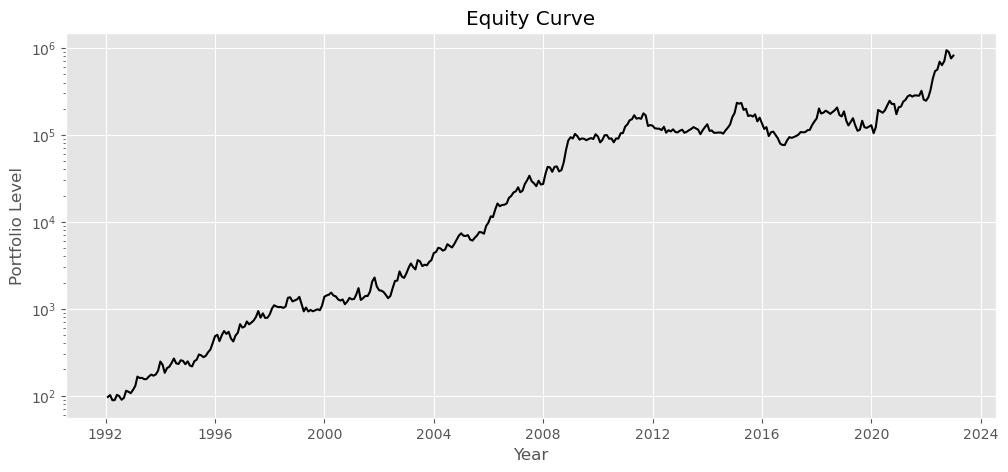

In [11]:
def Trend_Following(formation):
    end_measurement = formation
    slow_lookback = past_12.loc[formation]
    for i in Assets:
        slow_lookback[slow_lookback.index.isin(i)] = slow_lookback[slow_lookback.index.isin(i)].mean()
    slow_lookback[slow_lookback > 0]=1
    slow_lookback[slow_lookback < 0]=-1
    medium_lookback = past_3.loc[formation]
    for i in Assets:
        medium_lookback[medium_lookback.index.isin(i)] = medium_lookback[medium_lookback.index.isin(i)].mean()
    medium_lookback[medium_lookback > 0]=1
    medium_lookback[medium_lookback < 0]=-1
    fast_lookback = past_1.loc[formation]
    for i in Assets:
        fast_lookback[fast_lookback.index.isin(i)] = fast_lookback[fast_lookback.index.isin(i)].mean()
    fast_lookback[fast_lookback > 0]=1
    fast_lookback[fast_lookback < 0]=-1
    merged = pd.concat([slow_lookback,medium_lookback,fast_lookback],axis=1)
    merged['position'] = merged.sum(axis=1)
    vol_lookback = past_std.loc[end_measurement]
    vol_lookback.dropna(inplace=True)
    returns = monthly_returns.loc[end_measurement + MonthEnd(1),monthly_returns.columns.isin(merged.index)]
    wppp = pd.concat([returns,merged['position'],vol_lookback],axis=1)
    wppp = wppp[(wppp != 0).all(axis=1)]
    wppp.dropna(inplace=True)
    wppp.columns = ['1 Month Forward Returns','Signal','Ex Ante Vol Estimate']
    wppp['Inverse Volatility Weighting'] = (1/wppp['Ex Ante Vol Estimate'])/(sum(1/wppp['Ex Ante Vol Estimate']))
    wppp['IV * Signal'] = wppp['Inverse Volatility Weighting'] * wppp['Signal']
    wppp['Vol Targetted Weighting'] = wppp['IV * Signal'] * (0.30/sum(wppp['IV * Signal'].abs() * wppp['Ex Ante Vol Estimate']))
    wppp.dropna(inplace=True)
    wppp['Pounds'] = wppp['Vol Targetted Weighting'] * 500000
    Portfolio_Return = sum(wppp['1 Month Forward Returns'] * wppp['Vol Targetted Weighting'])
    return Portfolio_Return

Trend_Following_Returns = pd.DataFrame(data=[Trend_Following(i) for i in formation_dates],index=returns_dates)
equity_curve = 100*(1+Trend_Following_Returns*3.2).cumprod() 
fig = plt.figure(figsize=(12,5))
plt.plot(equity_curve.index,equity_curve,color='k')
plt.xlabel('Year')
plt.title('Equity Curve')
plt.yscale('log')
plt.ylabel('Portfolio Level')
plt.show

In [12]:
mean(Trend_Following_Returns)
vol(Trend_Following_Returns)
sharpe(Trend_Following_Returns)
MDD(Trend_Following_Returns)

Annual Return: 11.63%
Annual Volity: 12.63%
Sharpe Ratio: 0.92
Max Drawdown: -27.5%


In [13]:
skw(Trend_Following_Returns)

Skewness: 0.46


<Axes: title={'center': 'Annual returns'}, xlabel='Returns', ylabel='Year'>

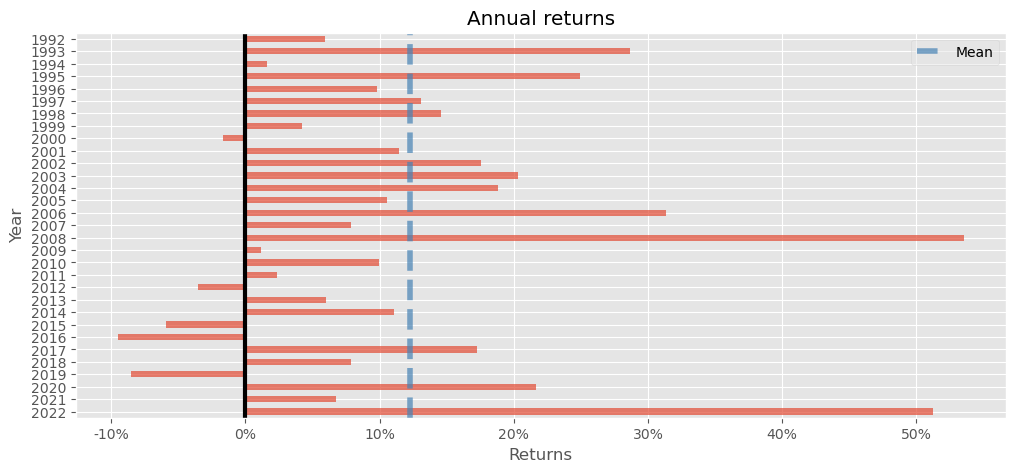

In [14]:
fig = plt.figure(figsize=(12,5))
pf.plot_annual_returns(Trend_Following_Returns)

<Axes: title={'center': 'Underwater plot'}, ylabel='Drawdown'>

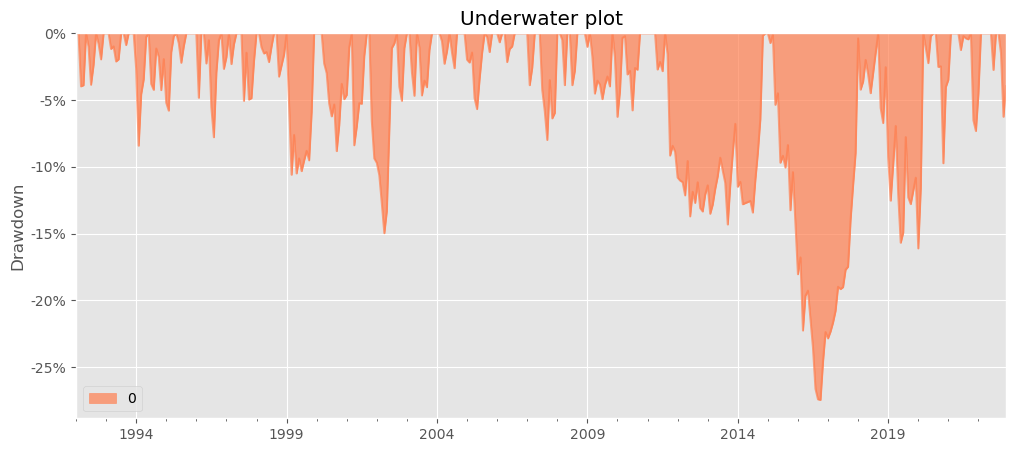

In [15]:
fig = plt.figure(figsize=(12,5))
pf.plot_drawdown_underwater(Trend_Following_Returns)

# Getting SP500 Data

In [16]:
SP500 = yfin.download('spy',start='1992-01-01',end='2022-12-31')['Adj Close']
SP500 = SP500.pct_change()
SP500_monthly = (SP500).resample('M').agg(lambda x: (x+1).prod()-1)
SP500_monthly

[*********************100%%**********************]  1 of 1 completed


Date
1993-01-31    0.000000
1993-02-28    0.010669
1993-03-31    0.022398
1993-04-30   -0.025588
1993-05-31    0.026970
                ...   
2022-08-31   -0.040802
2022-09-30   -0.092446
2022-10-31    0.081275
2022-11-30    0.055591
2022-12-31   -0.057628
Freq: M, Name: Adj Close, Length: 360, dtype: float64

In [17]:
Combined = pd.concat([Trend_Following_Returns[12:],SP500_monthly],axis=1)
Combined.columns = ['Trend Following','SP500']

In [18]:
Combined

,Trend Following,SP500
1993-01-31,0.036356,0.000000
1993-02-28,0.086088,0.010669
1993-03-31,-0.011729,0.022398
1993-04-30,0.001883,-0.025588
1993-05-31,-0.011350,0.026970
...,...,...
2022-08-31,0.034007,-0.040802
2022-09-30,0.106116,-0.092446
2022-10-31,-0.015014,0.081275
2022-11-30,-0.048216,0.055591


In [19]:
# Correlation of the 2 strategies. We can see the Trend Following strategy is very defensive
Combined.corr().iloc[0,1]

-0.2061374877149063

In [20]:
# 50/50 Allocation to both
Combined['50/50'] = Combined.sum(axis=1)/2

In [21]:
Combined

,Trend Following,SP500,50/50
1993-01-31,0.036356,0.000000,0.018178
1993-02-28,0.086088,0.010669,0.048379
1993-03-31,-0.011729,0.022398,0.005335
1993-04-30,0.001883,-0.025588,-0.011852
1993-05-31,-0.011350,0.026970,0.007810
...,...,...,...
2022-08-31,0.034007,-0.040802,-0.003397
2022-09-30,0.106116,-0.092446,0.006835
2022-10-31,-0.015014,0.081275,0.033131
2022-11-30,-0.048216,0.055591,0.003688


In [22]:
# Combined
mean(Combined,2)
vol(Combined,2)
sharpe(Combined,2)
MDD(Combined['50/50'])

Annual Return: 11.01%
Annual Volity: 8.75%
Sharpe Ratio: 1.26
Max Drawdown: -13.5%


<Axes: title={'center': 'Annual returns'}, xlabel='Returns', ylabel='Year'>

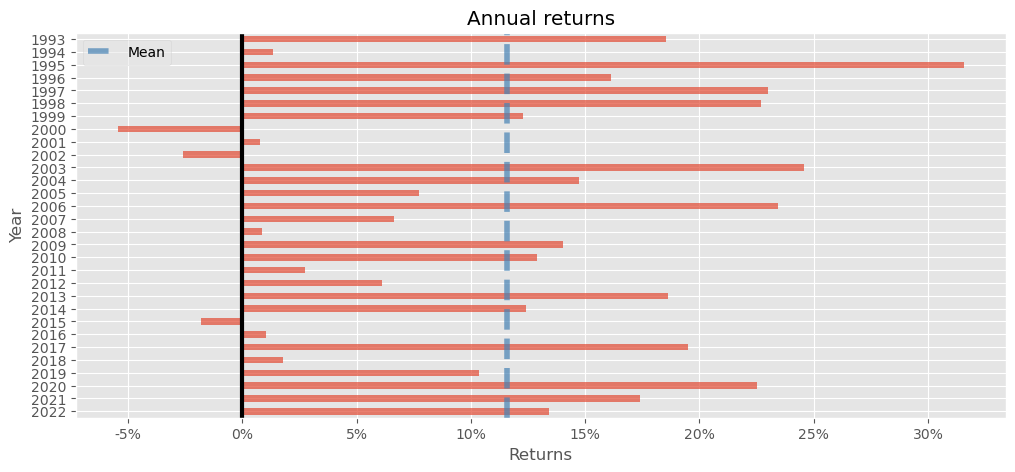

In [23]:
fig = plt.figure(figsize=(12,5))
pf.plot_annual_returns(Combined['50/50'])

<Axes: title={'center': 'Underwater plot'}, ylabel='Drawdown'>

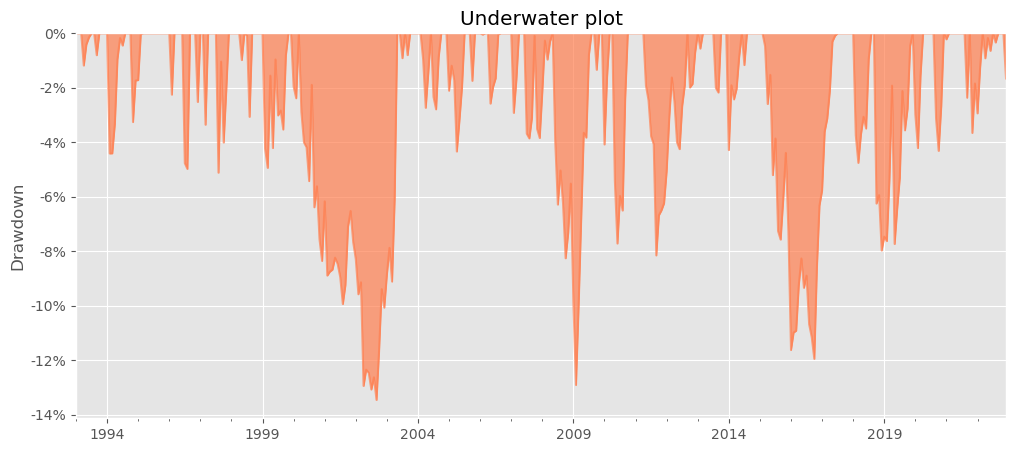

In [24]:
fig = plt.figure(figsize=(12,5))
pf.plot_drawdown_underwater(Combined['50/50'])

In [25]:
# Normalising strategy volatility to 20%
for i in Combined.columns:
    vol = Combined[i].std()*(12**0.5)
    scailer = 0.2/vol
    Combined[i] = Combined[i] * scailer

<function matplotlib.pyplot.show(close=None, block=None)>

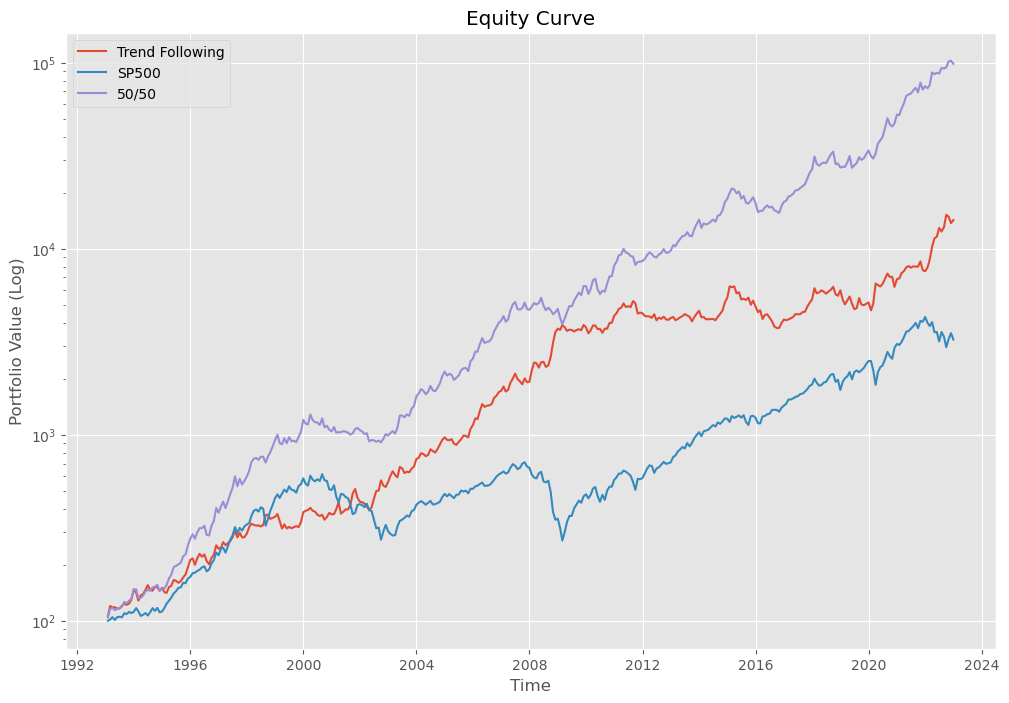

In [26]:
fig = plt.figure(figsize=(12,8))
plt.plot(Combined.index,(100*(Combined+1).cumprod()),label=Combined.columns)
plt.legend()
plt.yscale('log')
plt.ylabel('Portfolio Value (Log)')
plt.xlabel('Time')
plt.title('Equity Curve')
plt.show

# Insight

In [27]:
formation = dt.datetime(2006,1,31)
end_measurement = formation
slow_lookback = past_12.loc[end_measurement]
medium_looback = past_3.loc[end_measurement]
fast_lookback = past_1.loc[end_measurement]
merged = pd.concat([slow_lookback,medium_looback,fast_lookback],axis=1)
merged = merged[(merged != 0).all(axis=1)]
merged.dropna(inplace=True)
merged[merged > 0.0001] = 1
merged[merged < 0.0001] = -1
merged['position'] = merged.sum(axis=1)
vol_lookback = past_std.loc[end_measurement]
vol_lookback.dropna(inplace=True)
returns = monthly_returns.loc[end_measurement + MonthEnd(1),monthly_returns.columns.isin(merged.index)]
wppp = pd.concat([returns,merged['position'],vol_lookback],axis=1)
wppp = wppp[(wppp != 0).all(axis=1)]
wppp.dropna(inplace=True)
wppp['weighting'] = (1/wppp.iloc[:,2])/(sum(1/wppp.iloc[:,2])) * wppp.iloc[:,1]
months_profit = sum(wppp.iloc[:,0] * wppp.iloc[:,3])
momentum_profit = months_profit * (0.30/sum(wppp.iloc[:,3].abs() * (wppp.iloc[:,2])))
wppp['Pounds'] = ((wppp['weighting']/sum(wppp['weighting'])*100000000).abs()) * (0.30/sum(wppp.iloc[:,3].abs() * (wppp.iloc[:,2])))
wppp.columns = ['1 Month Forward Return','Signal','Ex Ante Vol Estimate','Weight','Notional Exposure £']
wppp['Notional Exposure £'] = wppp['Notional Exposure £'].apply(lambda x: '{:.2f}'.format(x))

In [28]:
wppp

,1 Month Forward Return,Signal,Ex Ante Vol Estimate,Weight,Notional Exposure £
CAC 40 Future,0.008364,3.0,0.119804,0.014614,3811103.46
DAX Future,0.018871,3.0,0.127769,0.013703,3573528.51
DJ EURO STOXX 50,0.019433,3.0,0.118416,0.014785,3855766.72
Dow Jones,0.013076,3.0,0.097659,0.017928,4675294.30
FTSE 100 Future,0.003831,3.0,0.092595,0.018908,4931018.36
...,...,...,...,...,...
Soybean Futures,-0.023559,3.0,0.262356,0.006673,1740331.65
British Pound,-0.014437,1.0,0.085958,0.006789,1770570.02
Canadian Dollar,0.001137,3.0,0.076274,0.022954,5986091.77
Euro,-0.020447,1.0,0.090235,0.006468,1686663.04
